In [55]:
import os
import string
import numpy as np
import pandas as pd
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re
import logging
import tensorflow as tf
# tf.enable_eager_execution()
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
logging.getLogger('tensorflow').setLevel(logging.FATAL)
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import unicodedata
import io
import time
import warnings
import sys
import nltk
from nltk.probability import FreqDist
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/hindienglish-corpora/Hindi_English_Truncated_Corpus.csv


In [56]:
path = "/kaggle/input/hindienglish-corpora/Hindi_English_Truncated_Corpus.csv"
data_hindi_english = pd.read_csv(path)

In [57]:
data_hindi_english.head()

,source,english_sentence,hindi_sentence
0,ted,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर..."
1,ted,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
2,indic2012,This percentage is even greater than the perce...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।
3,ted,what we really mean is that they're bad at not...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते
4,indic2012,.The ending portion of these Vedas is called U...,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है।


### Sanity Checking on data

In [58]:
print("NA Stats")
print(data_hindi_english.isna().sum())
print("\nRemoved instances with Null in english_sentence")
data_hindi_english = data_hindi_english[~ data_hindi_english['english_sentence'].isna()]

NA Stats
source              0
english_sentence    2
hindi_sentence      0
dtype: int64

Removed instances with Null in english_sentence


In [59]:
dict_words_english = []
dict_words_hindi = []

for row in data_hindi_english['english_sentence']:
    dict_words_english.extend(str(row).split(" "))
    
for row in data_hindi_english['hindi_sentence']:
    dict_words_hindi.extend(str(row).split(" "))

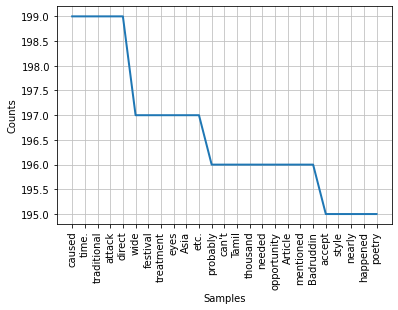

In [60]:
# Understanding context of the data
data_analysis_english = nltk.FreqDist(dict_words_english)
filter_words_english = dict([(m, n) for m, n in data_analysis_english.items() if n < 200 and len(m) > 3])
data_analysis_english = nltk.FreqDist(filter_words_english)
data_analysis_english.plot(25, cumulative=False)

# data_analysis_hindi = nltk.FreqDist(dict_words_hindi)
# filter_words_hindi = dict([(m, n) for m, n in data_analysis_hindi.items() if n < 200 and len(m) > 3])
# data_analysis_hindi = nltk.FreqDist(filter_words_hindi)
# data_analysis_hindi.plot(25, cumulative=False)

## Cleaning text in English
1. Convert words to lower case
2. Remove stop words (Will this be a good idea ?)
3. Remove the punctuations -> (Will this be a good idea ?)
4. Remove Numbers as english numbers to hindi number needs to be in a seperate model all together
5. Add start and end tags


In [61]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = w.rstrip().strip()
    return w

def hindi_preprocess_sentence(w):
    w = w.rstrip().strip()
    return w

def create_dataset():
    lines=pd.read_csv(path,encoding='utf-8')
    lines=lines.dropna()
    lines = lines[lines['source']=='ted']
    en = []
    hd = []
    for i, j in zip(lines['english_sentence'], lines['hindi_sentence']):
        en_1 = [preprocess_sentence(w) for w in i.split(' ')]
        en_1.append('<end>')
        en_1.insert(0, '<start>')
        hd_1 = [hindi_preprocess_sentence(w) for w in j.split(' ')]
        hd_1.append('<end>')
        hd_1.insert(0, '<start>')
        en.append(en_1)
        hd.append(hd_1)
    return hd, en

def max_length(tensor):
    return max(len(t) for t in tensor)

def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='',oov_token='<oov>')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,padding='post')
    return tensor, lang_tokenizer

def load_dataset():
    targ_lang, inp_lang = create_dataset()
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)
    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer


In [62]:
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset()
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)


### Create Train and Validation Set

In [63]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

31904 31904 7977 7977


### Create a Model

In [64]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 128
units = 256
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [72]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

In [73]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        hidden_with_time_axis = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

In [74]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.gru(x)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)
        return x, state, attention_weights

decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

In [75]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [81]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)


In [77]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)
        # Teacher forcing
        for t in range(1, targ.shape[1]):
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions)
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))      
    return batch_loss

In [82]:
# EPOCHS = 10

# for epoch in range(EPOCHS):
#     start = time.time()
#     enc_hidden = encoder.initialize_hidden_state()
#     total_loss = 0
#     for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
#         batch_loss = train_step(inp, targ, enc_hidden)
#         total_loss += batch_loss
#         if batch % 100 == 0:
#             print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
#                                                          batch,
#                                                          batch_loss.numpy()))
#     if (epoch + 1) % 2 == 0:
#         checkpoint.save(file_prefix = checkpoint_prefix)

#     print('Epoch {} Loss {:.4f}'.format(epoch + 1,
#                                       total_loss / steps_per_epoch))
#     print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

In [79]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    sentence = preprocess_sentence(sentence)
    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)
    result = ''
    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)
    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)
        predicted_id = tf.argmax(predictions[0]).numpy()
        result += targ_lang.index_word[predicted_id] + ' '
        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence
        dec_input = tf.expand_dims([predicted_id], 0)
    return result, sentence

In [80]:
def translate(sentence):
    result, sentence = evaluate(sentence)
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

In [53]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [54]:
translate(u'politicians do not have permission to do what needs to be done.')

Input: politicians do not have permission to do what needs to be done .
Predicted translation: जो कि ये है जो भी नहीं कर सकता है - <end> 


In [22]:
translate(u'I have understood the code')

Input: i have understood the code
Predicted translation: मैं यह पता कि यह कॉल आया था <end> 


In [34]:
evaluate(u'We know what to say')

('हम जानते हैं कि <end> ', 'we know what to say')